Dataset: https://www.kaggle.com/ronitf/heart-disease-uci

In [1]:
#Import the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.regression.linear_model as sm

In [2]:
data = pd.read_csv("insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Check for the null values
data.isnull().values.any()

False

In [4]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
# Check the data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Text(0.5, 1.0, 'Distribution of Charges')

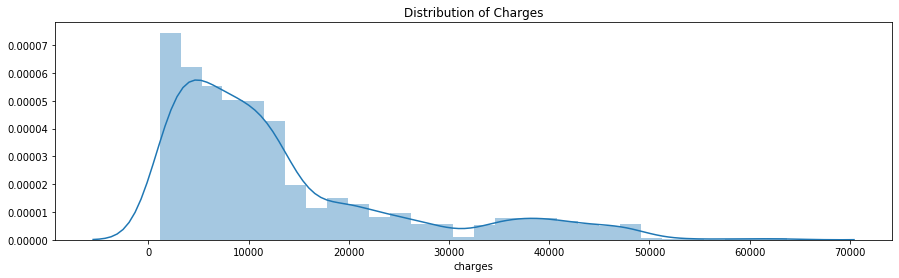

In [6]:
#Distribution of target data
fig = plt.figure(figsize = (15,4))
sns.distplot(data['charges']) 
plt.title('Distribution of Charges')

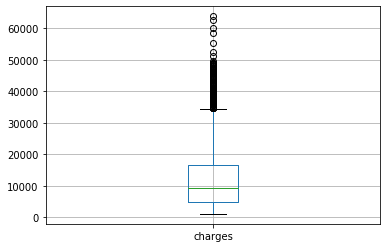

In [7]:
#Outlier detection using Univariate Analysis
data.boxplot(column = 'charges')

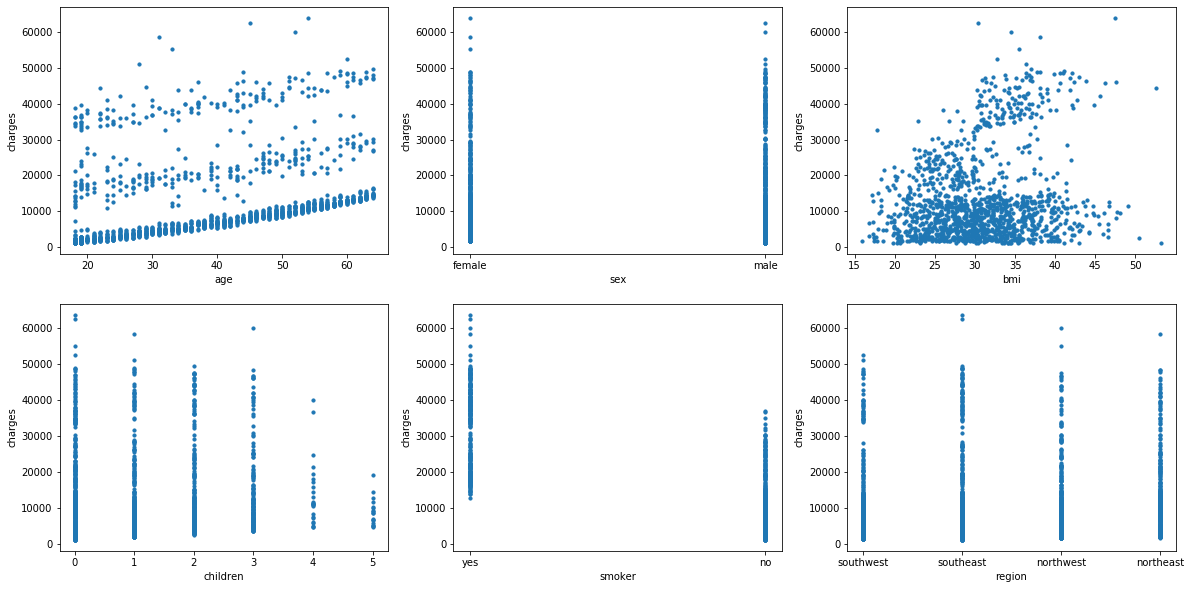

In [8]:
#Outlier detection using Bivariate Analysis

#Create feature and target
features = data.drop('charges',axis = 1)
target = data['charges']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))

i = 0
for ind,col in enumerate(features.columns):
    if ind < 3: 
        axes[i][ind].scatter(features[col],target,s=10)
        axes[i][ind].set_xlabel(col)
        axes[i][ind].set_ylabel("charges")
        ind=ind+1
    else: 
        axes[i+1][ind-3].scatter(features[col],target,s=10)
        axes[i+1][ind-3].set_xlabel(col)
        axes[i+1][ind-3].set_ylabel("charges")
        ind=ind+1
        
plt.show()

In [9]:
# Removing the outlier using IQR method
q25 = np.percentile(data['charges'], 25), 
q75 = np.percentile(data['charges'], 75)
iqr = q75 - q25

# calculate the outlier cutoff
cut_off = iqr*3.0
lower, upper = q25 - cut_off, q75 + cut_off

# identify outliers
outliers = [x for x in data['charges'] if x < lower or x > upper]
outliers

# remove the outliers
data1 = data[~data['bmi'].isin(outliers)]
data1.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [10]:
## data encoding
encoded_data = data1.copy()
encoded_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [11]:
encoded_data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [12]:
for col,col_data in encoded_data.iteritems():
    if col_data.dtype == object:
        col_data = pd.get_dummies(col_data,drop_first=True, prefix = col)
        encoded_data = encoded_data.join(col_data)
        encoded_data = encoded_data.drop(col,axis=1)

In [13]:
encoded_data

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,1,0,0
1334,18,31.920,0,2205.98080,0,0,0,0,0
1335,18,36.850,0,1629.83350,0,0,0,1,0
1336,21,25.800,0,2007.94500,0,0,0,0,1


In [14]:
encoded_data.columns

Index(['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')

In [15]:
# Check the correlation
correlations = encoded_data.corr()
correlations

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.000000,0.109272,0.042469,0.299008,-0.020856,-0.025019,-0.000407,-0.011642,0.010016
bmi,0.109272,1.000000,0.012759,0.198341,0.046371,0.003750,-0.135996,0.270025,-0.006205
children,0.042469,0.012759,1.000000,0.067998,0.017163,0.007673,0.024806,-0.023066,0.021914
charges,0.299008,0.198341,0.067998,1.000000,0.057292,0.787251,-0.039905,0.073982,-0.043210
sex_male,-0.020856,0.046371,0.017163,0.057292,1.000000,0.076185,-0.011156,0.017117,-0.004184
smoker_yes,-0.025019,0.003750,0.007673,0.787251,0.076185,1.000000,-0.036945,0.068498,-0.036945
region_northwest,-0.000407,-0.135996,0.024806,-0.039905,-0.011156,-0.036945,1.000000,-0.346265,-0.320829
region_southeast,-0.011642,0.270025,-0.023066,0.073982,0.017117,0.068498,-0.346265,1.000000,-0.346265
region_southwest,0.010016,-0.006205,0.021914,-0.043210,-0.004184,-0.036945,-0.320829,-0.346265,1.000000


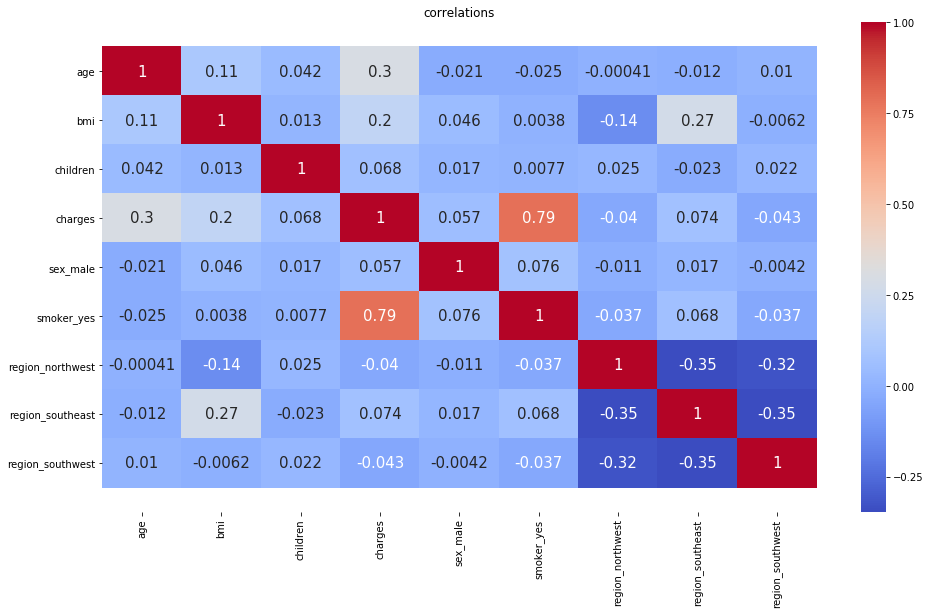

In [16]:
#Heatmap to visualize the correlation
plt.figure(figsize=(16,9))
ax = sns.heatmap(correlations,annot=True,cmap='coolwarm',annot_kws={'size': 15})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('correlations')
plt.show()

In [17]:
# Scale the data using StandardScaler
std = StandardScaler()
df_std = std.fit_transform(encoded_data)
df_std = pd.DataFrame(df_std, columns = encoded_data.columns)

In [18]:
df_std.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.453320,-0.908614,0.298584,-1.010519,1.970587,-0.566418,-0.611324,1.765481
1,-1.509965,0.509621,-0.078767,-0.953689,0.989591,-0.507463,-0.566418,1.635795,-0.566418
2,-0.797954,0.383307,1.580926,-0.728675,0.989591,-0.507463,-0.566418,1.635795,-0.566418
3,-0.441948,-1.305531,-0.908614,0.719843,0.989591,-0.507463,1.765481,-0.611324,-0.566418
4,-0.513149,-0.292556,-0.908614,-0.776802,0.989591,-0.507463,1.765481,-0.611324,-0.566418


In [19]:
#feature and target
X = df_std.drop('charges',axis = 1)
y = df_std['charges']

In [20]:
X.columns

Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

In [21]:
#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 0)

## Linear Regression

In [22]:
linearregressor = LinearRegression()
linearregressor.fit(X_train,y_train)
y_lr_pred = linearregressor.predict(X_test)

In [23]:
# print intercept and coefficients
print(linearregressor.intercept_)
print(linearregressor.coef_)
print(linearregressor.score(X,y))

-0.006322917259176027
[ 0.29751482  0.16888038  0.04705596 -0.00196374  0.78125195 -0.01990527
 -0.03656834 -0.02832036]
0.7505667109493459


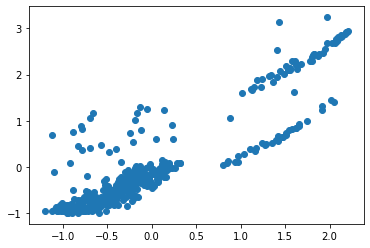

In [24]:
plt.scatter(y_lr_pred, y_test)

In [25]:
# Linear Regression Model Evaluation
#find out r-squared
r2_score = r2_score(y_test, y_lr_pred, sample_weight=None, multioutput='uniform_average')
print("Linear Regression - R2 Score : ",r2_score)

# find out mean suqred error
mse = mean_squared_error(y_test, y_lr_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_lr_pred)) 
print("Linear Regression - Mean Square Error : ", mse)
print("Linear Regression - Root Mean Square Error : ", rmse) 

Linear Regression - R2 Score :  0.7909160991789904
Linear Regression - Mean Square Error :  0.22752742168561832
Linear Regression - Root Mean Square Error :  0.4769983455795401


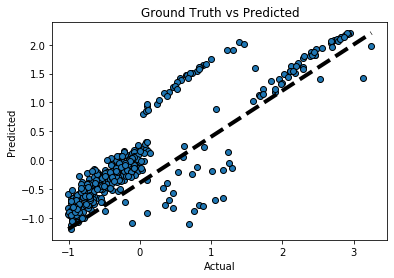

In [26]:
#Visualize goodness of fit
from sklearn.model_selection import cross_val_predict
fig, ax = plt.subplots()
ax.scatter(y_test, y_lr_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_lr_pred.min(), y_lr_pred.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title("Ground Truth vs Predicted")
plt.show()

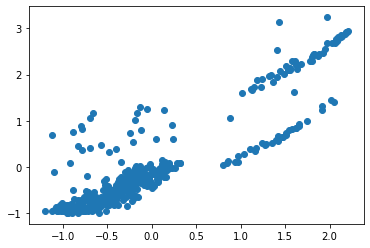

In [27]:
plt.scatter(y_lr_pred, y_test)

#### Calculating the Score

In [28]:
linearregressor.score(X_train,y_train)

0.7309569871174701

In [29]:
linearregressor.score(X_test,y_test)

0.7909160991789904

## Decision Tree

In [30]:
from sklearn.tree import DecisionTreeRegressor
decisionregressor = DecisionTreeRegressor(random_state = 0)
decisionregressor.fit(X_train,y_train)

DecisionTreeRegressor(random_state=0)

In [31]:
#Predicting the Test set results
y_dt_pred = decisionregressor.predict(X_test)

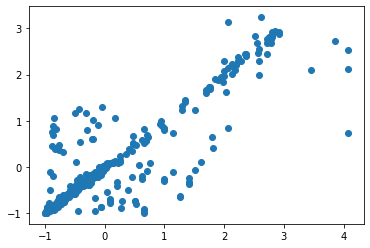

In [32]:
plt.scatter(y_dt_pred, y_test)

In [33]:
# Decision Tree Model Evaluation

#find out r-squared
from sklearn.metrics import r2_score
r2_score = r2_score(y_test, y_dt_pred, sample_weight=None, multioutput='uniform_average')
print("Decision Tree - R2 Score : ",r2_score)

# find out mean suqred error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_dt_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_dt_pred))
print("Decision Tree - Mean Square Error : ", mse)
print("Decision Tree - Root Mean Square Error : ", rmse) 

Decision Tree - R2 Score :  0.7236113654503731
Decision Tree - Mean Square Error :  0.30076918000549474
Decision Tree - Root Mean Square Error :  0.5484242700733573


## Random Forest

In [34]:
# Fitting the Random Forest Regression to dataset(with 10 trees)
from sklearn.ensemble import RandomForestRegressor
randomforestregressor = RandomForestRegressor(n_estimators=10,random_state = 0)
randomforestregressor.fit(X_train,y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [35]:
#Predicting the Test set results
y_rf_pred = randomforestregressor.predict(X_test)

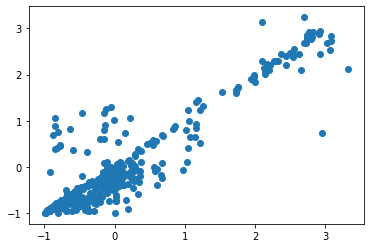

In [36]:
plt.scatter(y_rf_pred, y_test)

In [37]:
# Decision Tree Model Evaluation

#find out r-squared
from sklearn.metrics import r2_score
r2_score = r2_score(y_test, y_rf_pred, sample_weight=None, multioutput='uniform_average')
print("Random Forest - R2 Score : ",r2_score)

# find out mean suqred error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_rf_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_rf_pred))
print("Random Forest - Mean Square Error : ", mse)
print("Random Forest - Root Mean Square Error : ", rmse)

Random Forest - R2 Score :  0.8312006720151037
Random Forest - Mean Square Error :  0.1836893023702821
Random Forest - Root Mean Square Error :  0.428589899986318


## AdaBoost

In [38]:
# Fitting the AdaBoost Regression to dataset
from sklearn.ensemble import AdaBoostRegressor
AdaBoostRegressor = AdaBoostRegressor(n_estimators=10,random_state = 0)
AdaBoostRegressor.fit(X_train,y_train)

AdaBoostRegressor(n_estimators=10, random_state=0)

In [39]:
#Predicting the Test set results
y_ab_pred = AdaBoostRegressor.predict(X_test)

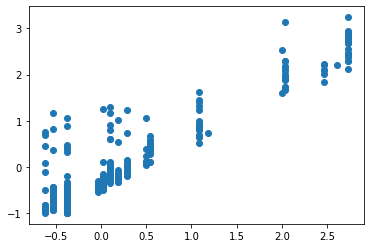

In [40]:
plt.scatter(y_ab_pred, y_test)

In [41]:
# AdaBoost Model Evaluation

#find out r-squared
from sklearn.metrics import r2_score
r2_score = r2_score(y_test, y_ab_pred, sample_weight=None, multioutput='uniform_average')
print("Ada Boost - R2 Score : ",r2_score)

# find out mean suqred error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_ab_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_ab_pred))
print("Ada Boost - Mean Square Error : ", mse)
print("Ada Boost - Root Mean Square Error : ", rmse)

Ada Boost - R2 Score :  0.8447476929154871
Ada Boost - Mean Square Error :  0.16894728385579055
Ada Boost - Root Mean Square Error :  0.41103197424992444


## Gradient Boosting

In [42]:
# Fitting the Gradient Boosting Regression to dataset
from sklearn.ensemble import GradientBoostingRegressor
GradientBoosting = GradientBoostingRegressor(n_estimators=10,random_state = 0)
GradientBoosting.fit(X_train,y_train)

GradientBoostingRegressor(n_estimators=10, random_state=0)

In [43]:
#Predicting the Test set results
y_gb_pred = GradientBoosting.predict(X_test)

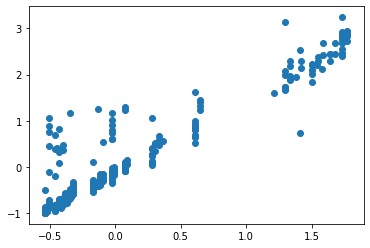

In [44]:
plt.scatter(y_gb_pred, y_test)

In [45]:
# Gradient Boost Model Evaluation

#find out r-squared
from sklearn.metrics import r2_score
r2_score = r2_score(y_test, y_gb_pred, sample_weight=None, multioutput='uniform_average')
print("Gradient Boost - R2 Score : ",r2_score)

# find out mean suqred error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_gb_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_gb_pred))
print("Gradient Boost - Mean Square Error : ", mse)
print("Gradient Boost - Root Mean Square Error : ", rmse)

Gradient Boost - R2 Score :  0.7835945902932497
Gradient Boost - Mean Square Error :  0.23549476892316096
Gradient Boost - Root Mean Square Error :  0.485278032599005


## XGBoost

In [46]:
#hyper parameter optimization

params = {
    "colsample_bytree":[0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5],
    "gamma"           :[0.0,0.1,0.2,0.3,0.4],
    "learning_rate"   :[0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth"       :[3,4,5,6,7,8,9,10,11,12,13,14,15],
    "n_estimators"    :[5,6,7,8,9,10,11,12]
}

In [47]:
regressor = XGBRegressor()

In [48]:
# hyperparameter optimization
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

random_search = RandomizedSearchCV(regressor, param_distributions=params, n_iter=10)

random_search.fit(X,y)

C:\Users\abdewang.ORADEV\AppData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\abdewang.ORADEV\AppData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\abdewang.ORADEV\AppData\anaconda3\lib\site-packages\xgboost\sklearn.py", line 549, in fit
    callbacks=callbacks)
  File "C:\Users\abdewang.ORADEV\AppData\anaconda3\lib\site-packages\xgboost\training.py", line 209, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "C:\Users\abdewang.ORADEV\AppData\anaconda3\lib\site-packages\xgboost\training.py", line 74, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Users\abdewang.ORADEV\AppData\anaconda3\lib\site-packages\xgboost\core.py", line 1249, in upd

C:\Users\abdewang.ORADEV\AppData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\abdewang.ORADEV\AppData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\abdewang.ORADEV\AppData\anaconda3\lib\site-packages\xgboost\sklearn.py", line 549, in fit
    callbacks=callbacks)
  File "C:\Users\abdewang.ORADEV\AppData\anaconda3\lib\site-packages\xgboost\training.py", line 209, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "C:\Users\abdewang.ORADEV\AppData\anaconda3\lib\site-packages\xgboost\training.py", line 74, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Users\abdewang.ORADEV\AppData\anaconda3\lib\site-packages\xgboost\core.py", line 1249, in upd

C:\Users\abdewang.ORADEV\AppData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\abdewang.ORADEV\AppData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\abdewang.ORADEV\AppData\anaconda3\lib\site-packages\xgboost\sklearn.py", line 549, in fit
    callbacks=callbacks)
  File "C:\Users\abdewang.ORADEV\AppData\anaconda3\lib\site-packages\xgboost\training.py", line 209, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "C:\Users\abdewang.ORADEV\AppData\anaconda3\lib\site-packages\xgboost\training.py", line 74, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Users\abdewang.ORADEV\AppData\anaconda3\lib\site-packages\xgboost\core.py", line 1249, in upd

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs...
                                          reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
          

In [49]:
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=14,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=8, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [50]:
random_search.best_params_

{'n_estimators': 8,
 'max_depth': 14,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'colsample_bytree': 1.0}

In [51]:
# Fitting the Gradient Boosting Regression to dataset
XGB = XGBRegressor(n_estimators=12,max_depth = 5,learning_rate = 0.3,gamma = 0.3,colsample_bytree = 1.0, random_state = 0)
XGB.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.3, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=12, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [52]:
#Predicting the Test set results
y_xgb_pred = XGB.predict(X_test)

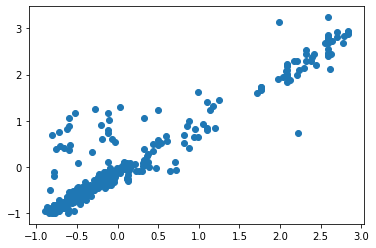

In [53]:
plt.scatter(y_xgb_pred, y_test)

In [54]:
# model score(train)
XGB.score(X_train,y_train)

0.8951752379496261

In [55]:
# model score(test)
XGB.score(X_test,y_test)

0.885181344337482

In [56]:
# XGBoost Model Evaluation

#find out r-squared
from sklearn.metrics import r2_score
r2_score = r2_score(y_test, y_xgb_pred, sample_weight=None, multioutput='uniform_average')
print("XG Boost - R2 Score : ",r2_score)

# find out mean suqred error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_xgb_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_xgb_pred))
print("XG Boost - Mean Square Error : ", mse)
print("XG Boost - Root Mean Square Error : ", rmse)

XG Boost - R2 Score :  0.885181344337482
XG Boost - Mean Square Error :  0.12494693556853932
XG Boost - Root Mean Square Error :  0.35347833818855057
